#Importing all the important libraries which will be needed throughtout the project

In [1]:
# General-purpose
import os
import random
from collections import Counter

# Numerical and data processing
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2
from skimage import io, exposure, filters, util
from skimage.util import img_as_ubyte, img_as_float
from scipy import ndimage

# Deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


# Using kaggle api key for using dataset from kaggle locally without directly downloading it

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhilgupta2005","key":"0671963a83428554a31f4abb4d7a12b1"}'}

#Dataset Download Using kagglehub

In [3]:
import os
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

print("Dataset contents:", os.listdir(path))


Path to dataset files: /kaggle/input/chest-xray-pneumonia
Dataset contents: ['chest_xray']


#  Listing Dataset Directory

In [4]:
base_dir =  "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Base Directory:", base_dir)
print("Train Directory:", train_dir)
print("Validation Directory:", val_dir)
print("Test Directory:", test_dir)

Base Directory: /kaggle/input/chest-xray-pneumonia/chest_xray
Train Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Validation Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test


#Defining image shape , batch_size and epochs for model training

In [5]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 1)

batch_size = 32
epochs = 5

# Perfroming data augmentation(scaling,rotating) on training dataset to prevent Overfitting

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation on test and val dataset , meant for testing purposes only

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5216 images belonging to 2 classes.


In [9]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 16 images belonging to 2 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 624 images belonging to 2 classes.


#Now below are some functions for image preprocessing and visulaization

In [11]:
# This function count_images() is used to count the number of images in each class
# (NORMAL and PNEUMONIA) within the train, val, and test folders of a dataset


def count_images(base_path):
    categories = ['NORMAL', 'PNEUMONIA']
    counts = {}

    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(base_path, subset)
        subset_counts = {}

        for category in categories:
            category_path = os.path.join(subset_path, category)
            if os.path.exists(category_path):
                image_count = len(os.listdir(category_path))
                subset_counts[category] = image_count

        counts[subset] = subset_counts

    return counts

In [12]:
# This function visualize_dataset_distribution(counts) is designed to create a bar plot that visually shows how many images there are in each category
# (NORMAL and PNEUMONIA) across the train, val, and test subsets of our dataset.


def visualize_dataset_distribution(counts):
    # Prepare data for plotting
    data = {
        'Subset': [],
        'Category': [],
        'Count': []
    }

    for subset, subset_counts in counts.items():
        for category, count in subset_counts.items():
            data['Subset'].append(subset)
            data['Category'].append(category)
            data['Count'].append(count)

    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(x='Subset', y='Count', hue='Category', data=df)
    plt.title('Dataset Distribution')
    plt.xlabel('Dataset Subset')
    plt.ylabel('Number of Images')

    # Add count labels on bars
    for p in chart.patches:
        chart.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

    plt.tight_layout()
    plt.savefig('dataset_distribution.png')
    plt.show()

In [13]:
# The function load_sample_images() is designed to load and return a few random sample images (in grayscale)
# from the training set of your dataset for both NORMAL and PNEUMONIA categories

def load_sample_images(base_path, num_samples=4):
    normal_images = []
    pneumonia_images = []
    normal_paths = []
    pneumonia_paths = []

    # Load from training set
    normal_dir = os.path.join(base_path, 'train', 'NORMAL')
    pneumonia_dir = os.path.join(base_path, 'train', 'PNEUMONIA')

    normal_files = os.listdir(normal_dir)
    pneumonia_files = os.listdir(pneumonia_dir)

    # Randomly select samples
    normal_samples = random.sample(normal_files, min(num_samples, len(normal_files)))
    pneumonia_samples = random.sample(pneumonia_files, min(num_samples, len(pneumonia_files)))

    # Load images
    for file in normal_samples:
        path = os.path.join(normal_dir, file)
        img = cv2.imread(path, 0)  # Read as grayscale
        normal_images.append(img)
        normal_paths.append(path)

    for file in pneumonia_samples:
        path = os.path.join(pneumonia_dir, file)
        img = cv2.imread(path, 0)  # Read as grayscale
        pneumonia_images.append(img)
        pneumonia_paths.append(path)

    return normal_images, pneumonia_images, normal_paths, pneumonia_paths

In [14]:
# The function display_sample_images() is built to visually compare
# chest X-ray images of NORMAL and PNEUMONIA cases side by side in a single plot

def display_sample_images(normal_images, pneumonia_images, title="Sample X-ray Images"):
    num_samples = min(len(normal_images), len(pneumonia_images))

    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Display normal images
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(normal_images[i], cmap='gray')
        plt.title(f'Normal {i+1}')
        plt.axis('off')

        # Display pneumonia images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(pneumonia_images[i], cmap='gray')
        plt.title(f'Pneumonia {i+1}')
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

In [15]:
# The function plot_histograms() is used to compare the pixel intensity
# distributions (histograms) of NORMAL and PNEUMONIA X-ray images side by side.

def plot_histograms(normal_images, pneumonia_images):
    num_samples = min(len(normal_images), len(pneumonia_images))

    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        # Histogram for normal images
        plt.subplot(2, num_samples, i + 1)
        hist = cv2.calcHist([normal_images[i]], [0], None, [256], [0, 256])
        plt.plot(hist)
        plt.title(f'Normal {i+1} Histogram')
        plt.xlim([0, 256])
        plt.grid(alpha=0.3)

        # Histogram for pneumonia images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        hist = cv2.calcHist([pneumonia_images[i]], [0], None, [256], [0, 256])
        plt.plot(hist)
        plt.title(f'Pneumonia {i+1} Histogram')
        plt.xlim([0, 256])
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('histogram_comparison.png')
    plt.show()

In [16]:
# we have used histogram equlaizer to
# enhance the contrast of grayscale images by applying histogram equalization.

def apply_histogram_equalization(images):
    equalized_images = []

    for img in images:
        # Apply histogram equalization
        img_eq = cv2.equalizeHist(img)
        equalized_images.append(img_eq)

    return equalized_images

In [17]:
# We have used apply_gaussian_filter() to reduce noise and smooth images.

def apply_gaussian_filter(images, sigma=1.0):
    filtered_images = []

    for img in images:
        # Apply Gaussian filter
        img_filtered = filters.gaussian(img, sigma=sigma, preserve_range=True).astype(np.uint8)
        filtered_images.append(img_filtered)

    return filtered_images

In [18]:
def visualize_dataset():
    print("Analyzing dataset distribution...")
    counts = count_images(base_dir)
    visualize_dataset_distribution(counts)

    print("\nLoading sample images...")
    normal_images, pneumonia_images, normal_paths, pneumonia_paths = load_sample_images(base_dir, num_samples=4)
    display_sample_images(normal_images, pneumonia_images, "Original X-ray Images")

    print("\nDisplaying image histograms...")
    plot_histograms(normal_images, pneumonia_images)

In [19]:
def apply_preprocessing():
    print("Loading sample images for preprocessing...")
    normal_images, pneumonia_images, _, _ = load_sample_images(base_dir, num_samples=2)

    # Combine samples for processing
    all_samples = normal_images + pneumonia_images
    all_labels = ["Normal"] * len(normal_images) + ["Pneumonia"] * len(pneumonia_images)

    # Apply histogram equalization
    print("Applying histogram equalization...")
    equalized_images = apply_histogram_equalization(all_samples)
    display_preprocessing_results(all_samples, equalized_images, all_labels, "Histogram Equalization")

    print("Applying Gaussian filtering...")
    gaussian_images = apply_gaussian_filter(all_samples)
    display_preprocessing_results(all_samples, gaussian_images, all_labels, "Gaussian Filter")


In [20]:
def display_preprocessing_results(original_images, processed_images, labels, title):
    n = len(original_images)
    plt.figure(figsize=(15, 3 * n))

    for i in range(n):
        # Display original image
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f'Original ({labels[i]})')
        plt.axis('off')

        # Display processed image
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(processed_images[i], cmap='gray')
        plt.title(f'Processed ({labels[i]})')
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

    # Plot histograms for each pair
    plt.figure(figsize=(15, 3 * n))
    for i in range(n):
        # Original histogram
        plt.subplot(n, 2, 2*i + 1)
        hist_orig = cv2.calcHist([original_images[i]], [0], None, [256], [0, 256])
        plt.plot(hist_orig)
        plt.title(f'Original Histogram ({labels[i]})')
        plt.xlim([0, 256])

        # Processed histogram
        plt.subplot(n, 2, 2*i + 2)
        hist_proc = cv2.calcHist([processed_images[i]], [0], None, [256], [0, 256])
        plt.plot(hist_proc)
        plt.title(f'Processed Histogram ({labels[i]})')
        plt.xlim([0, 256])

    plt.suptitle(f'Histogram Comparison - {title}')
    plt.tight_layout()
    plt.savefig(f'histogram_{title.replace(" ", "_").lower()}.png')
    plt.show()

Analyzing dataset distribution...


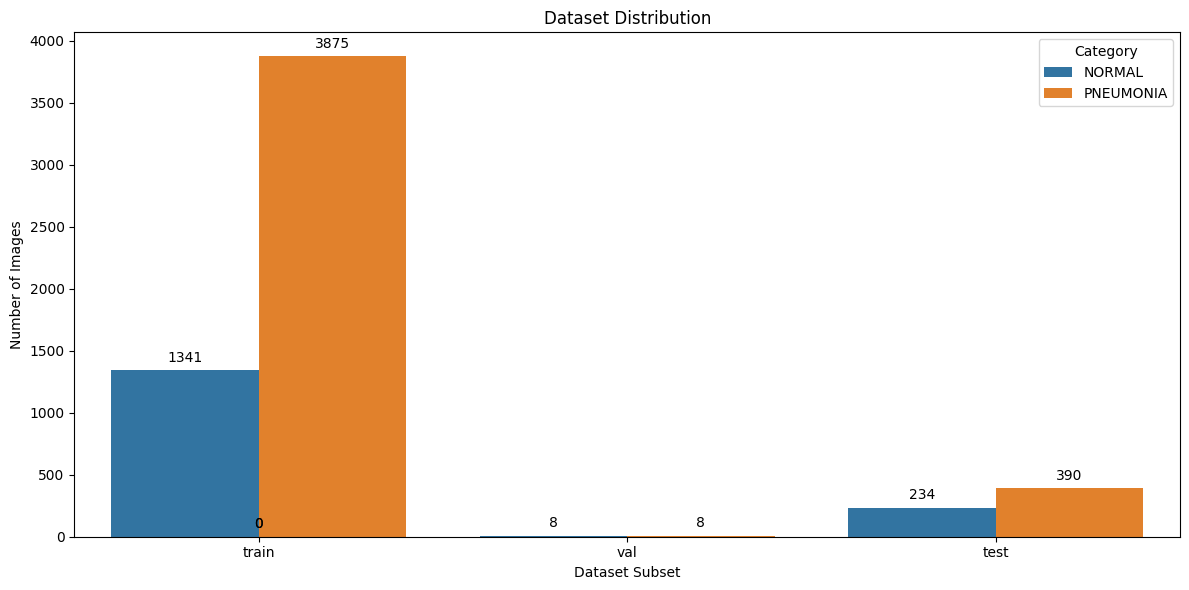


Loading sample images...


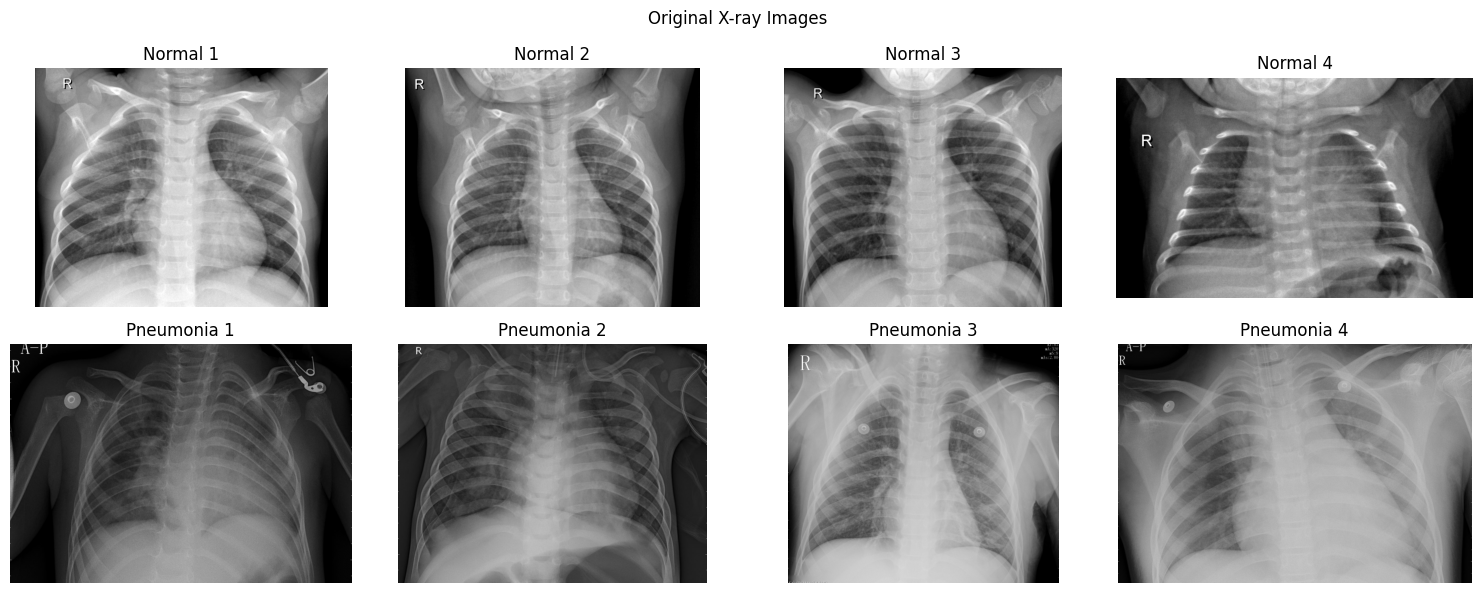


Displaying image histograms...


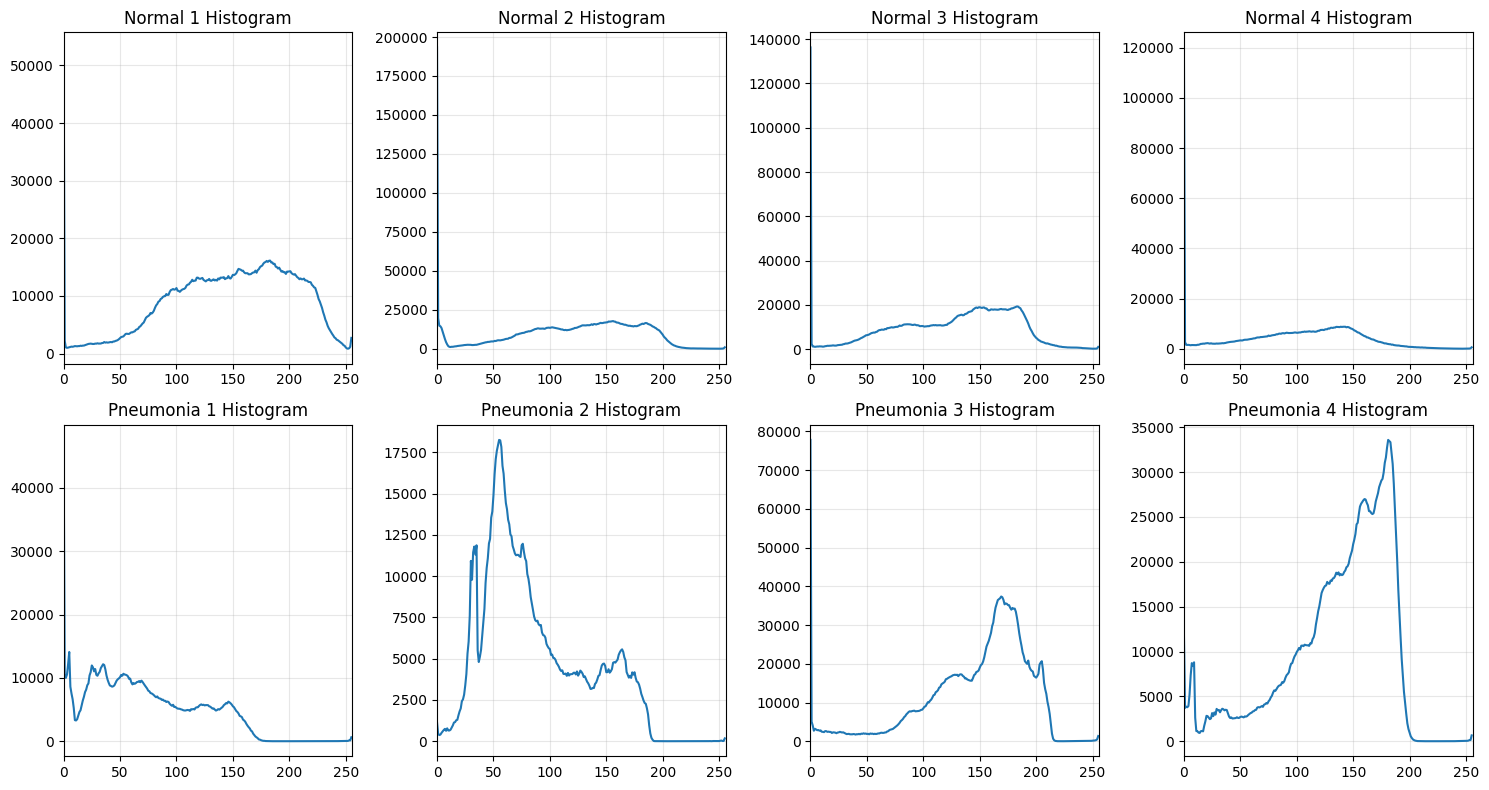

In [21]:
visualize_dataset()

Loading sample images for preprocessing...
Applying histogram equalization...


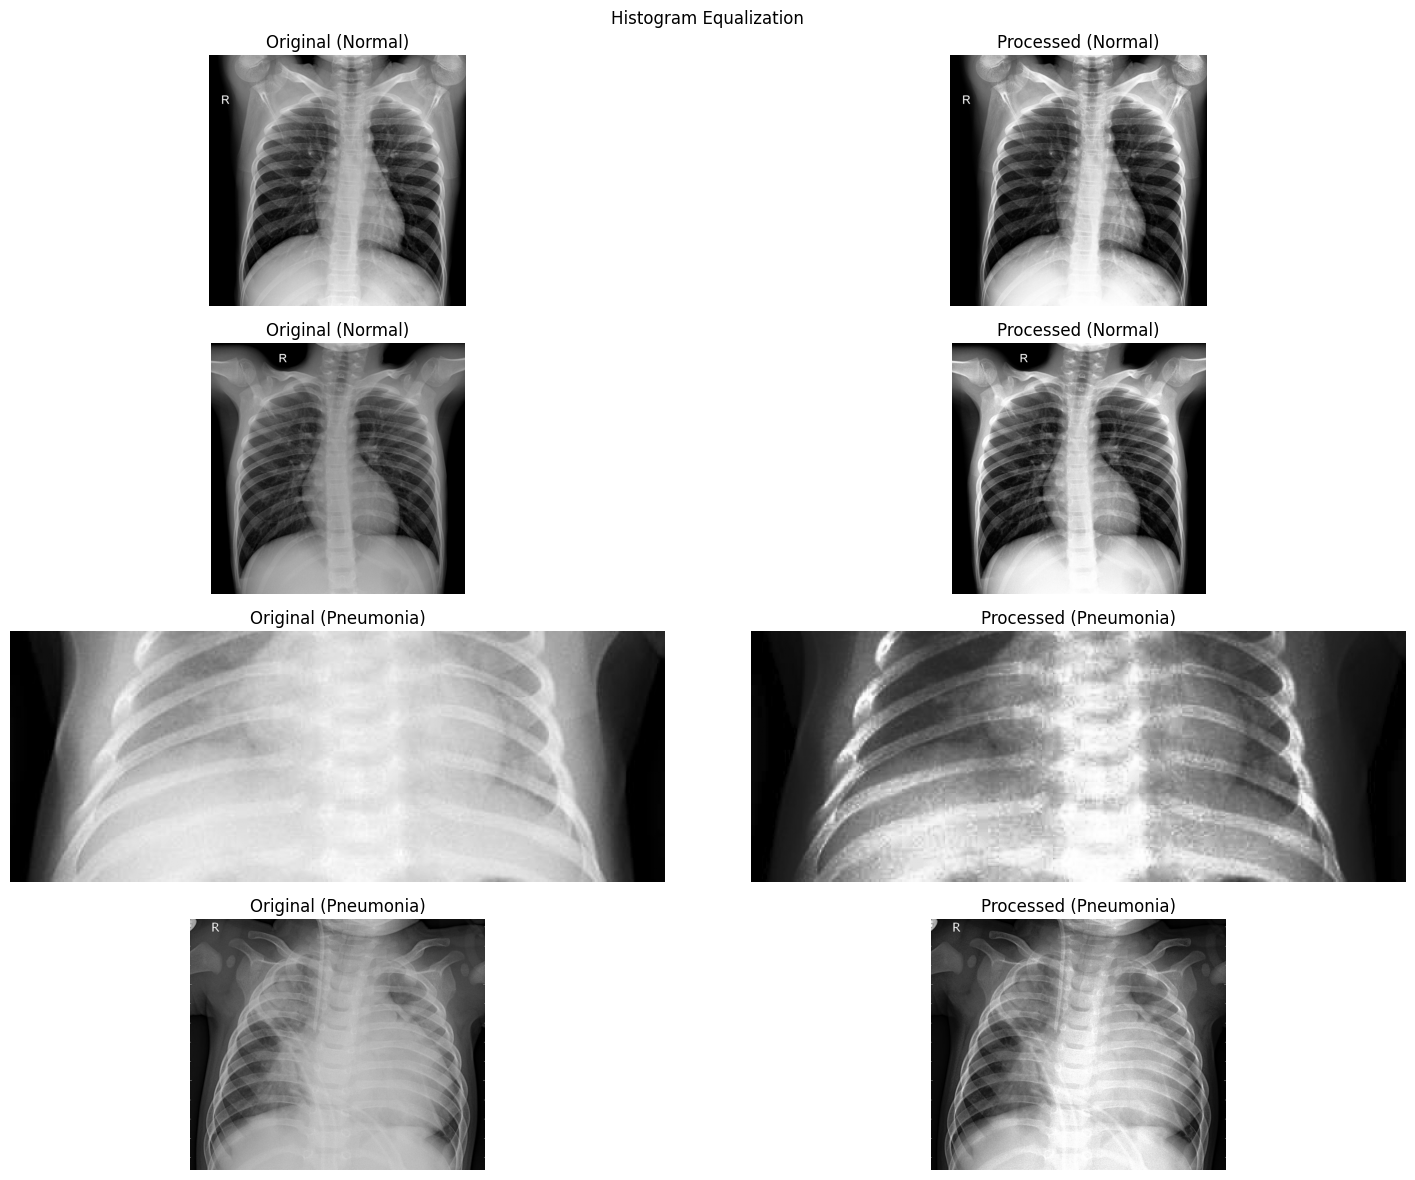

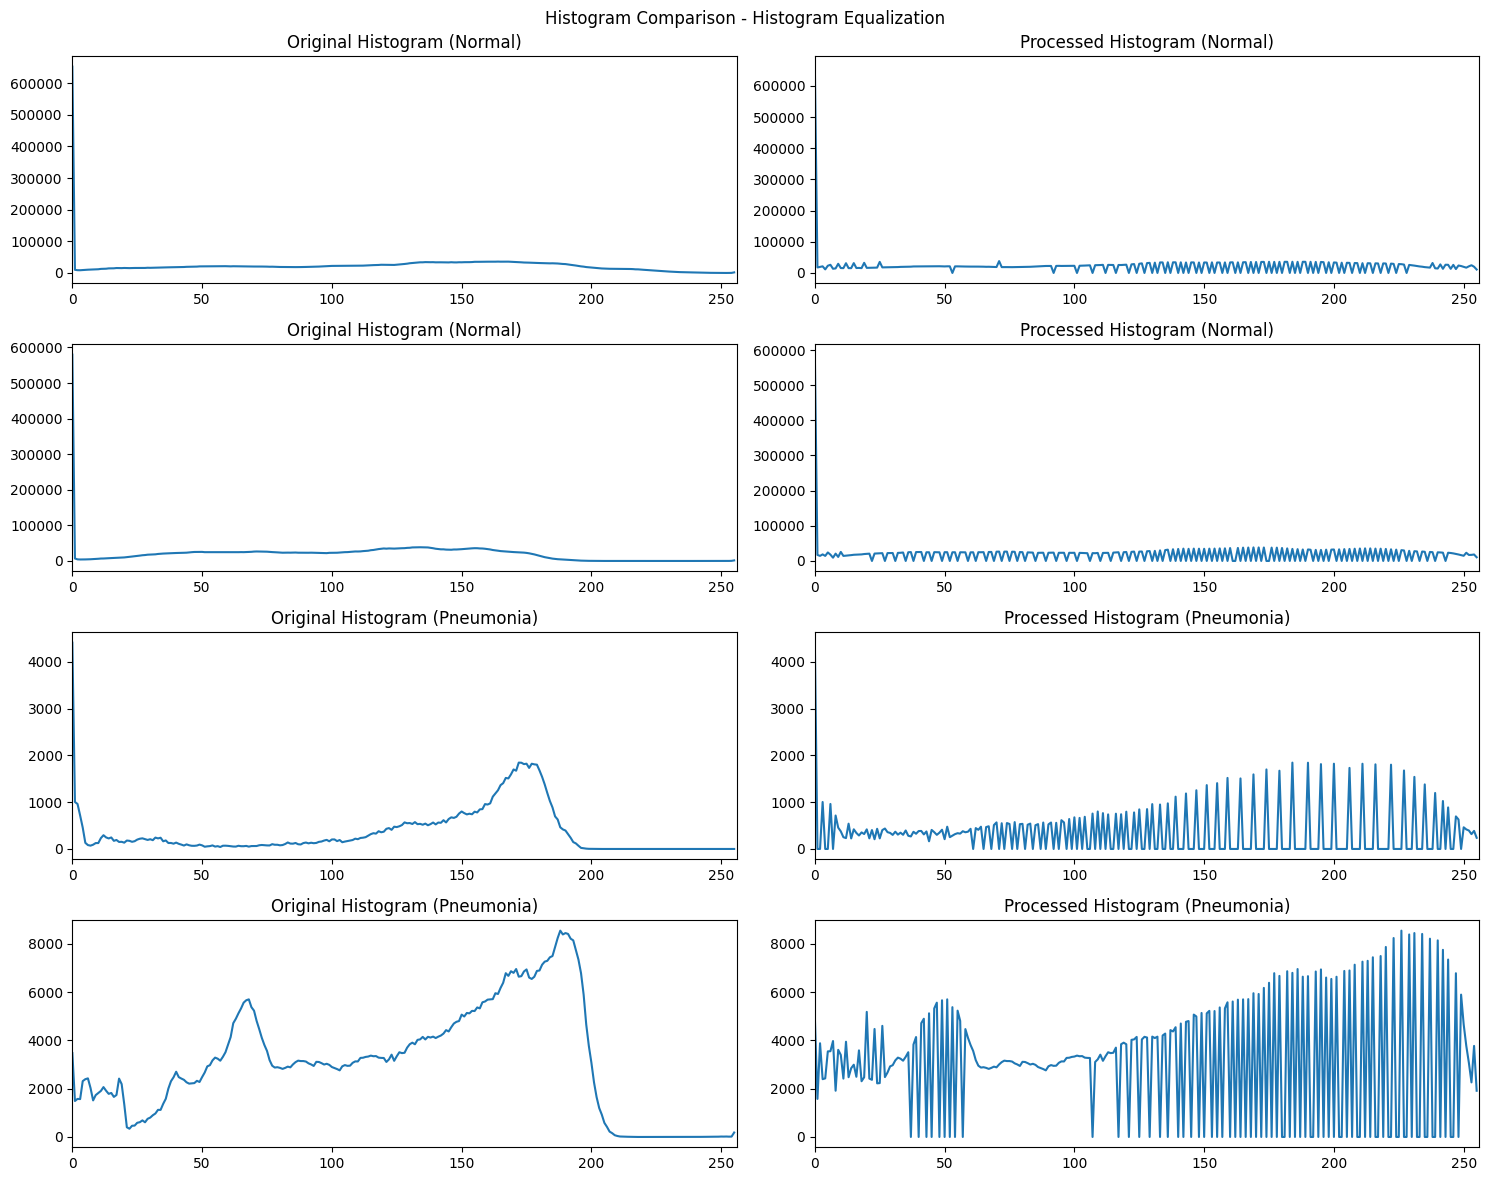

Applying Gaussian filtering...


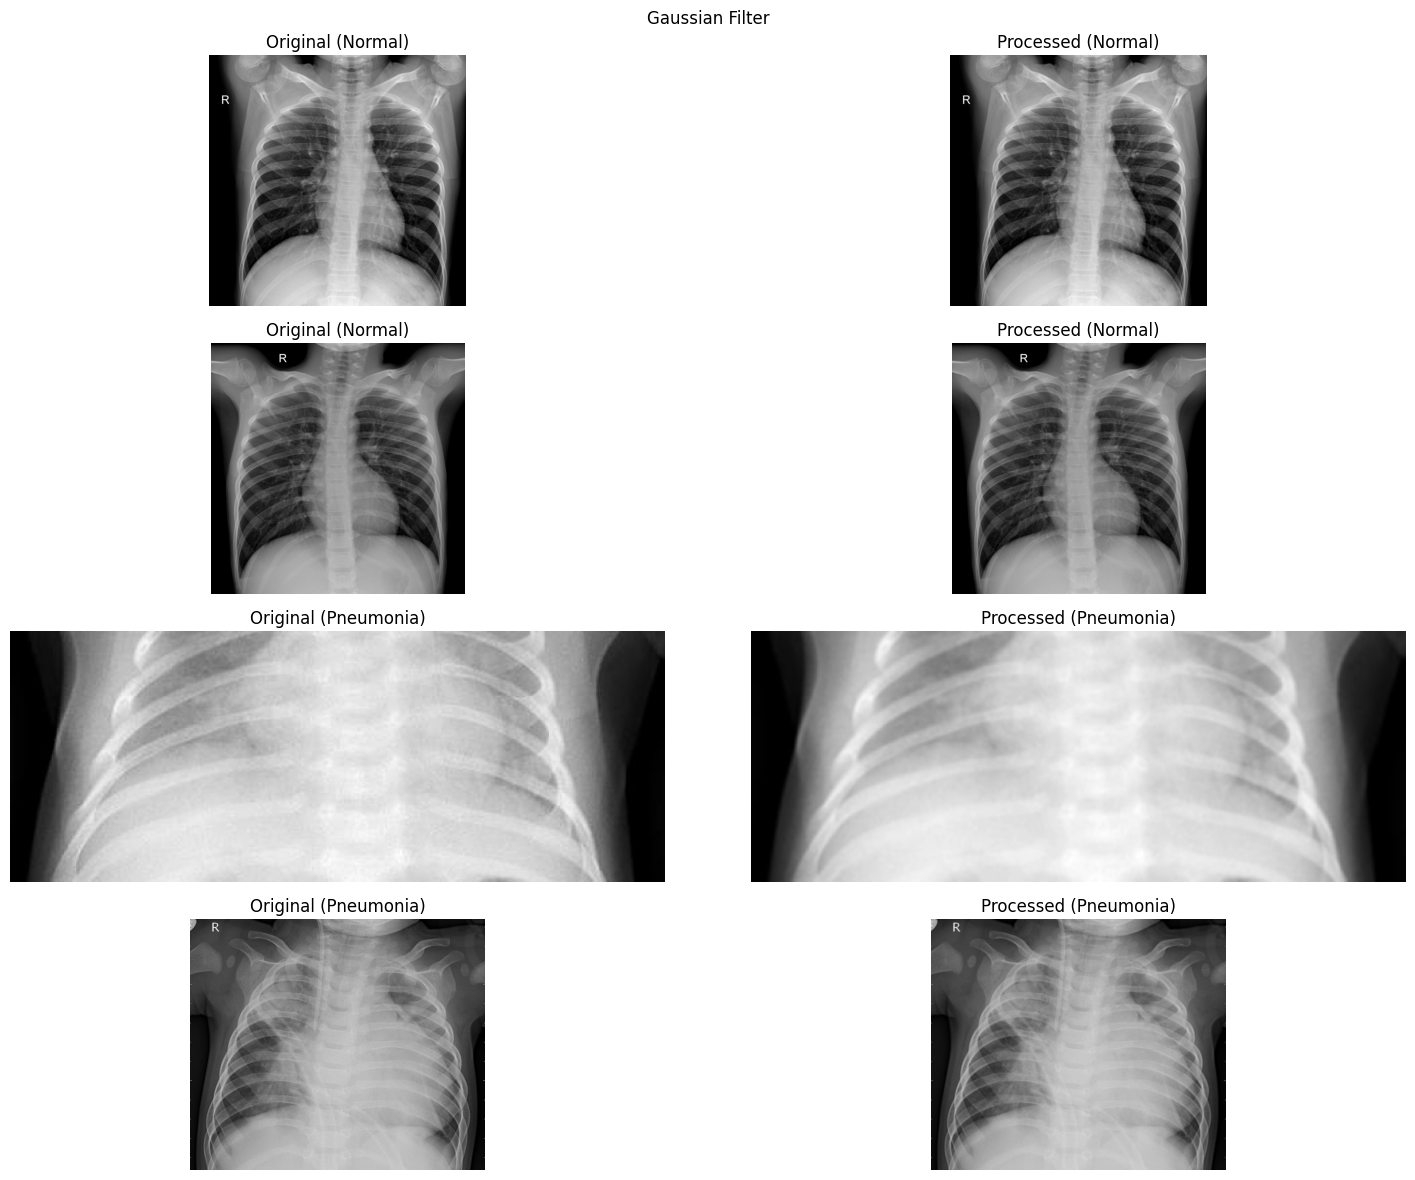

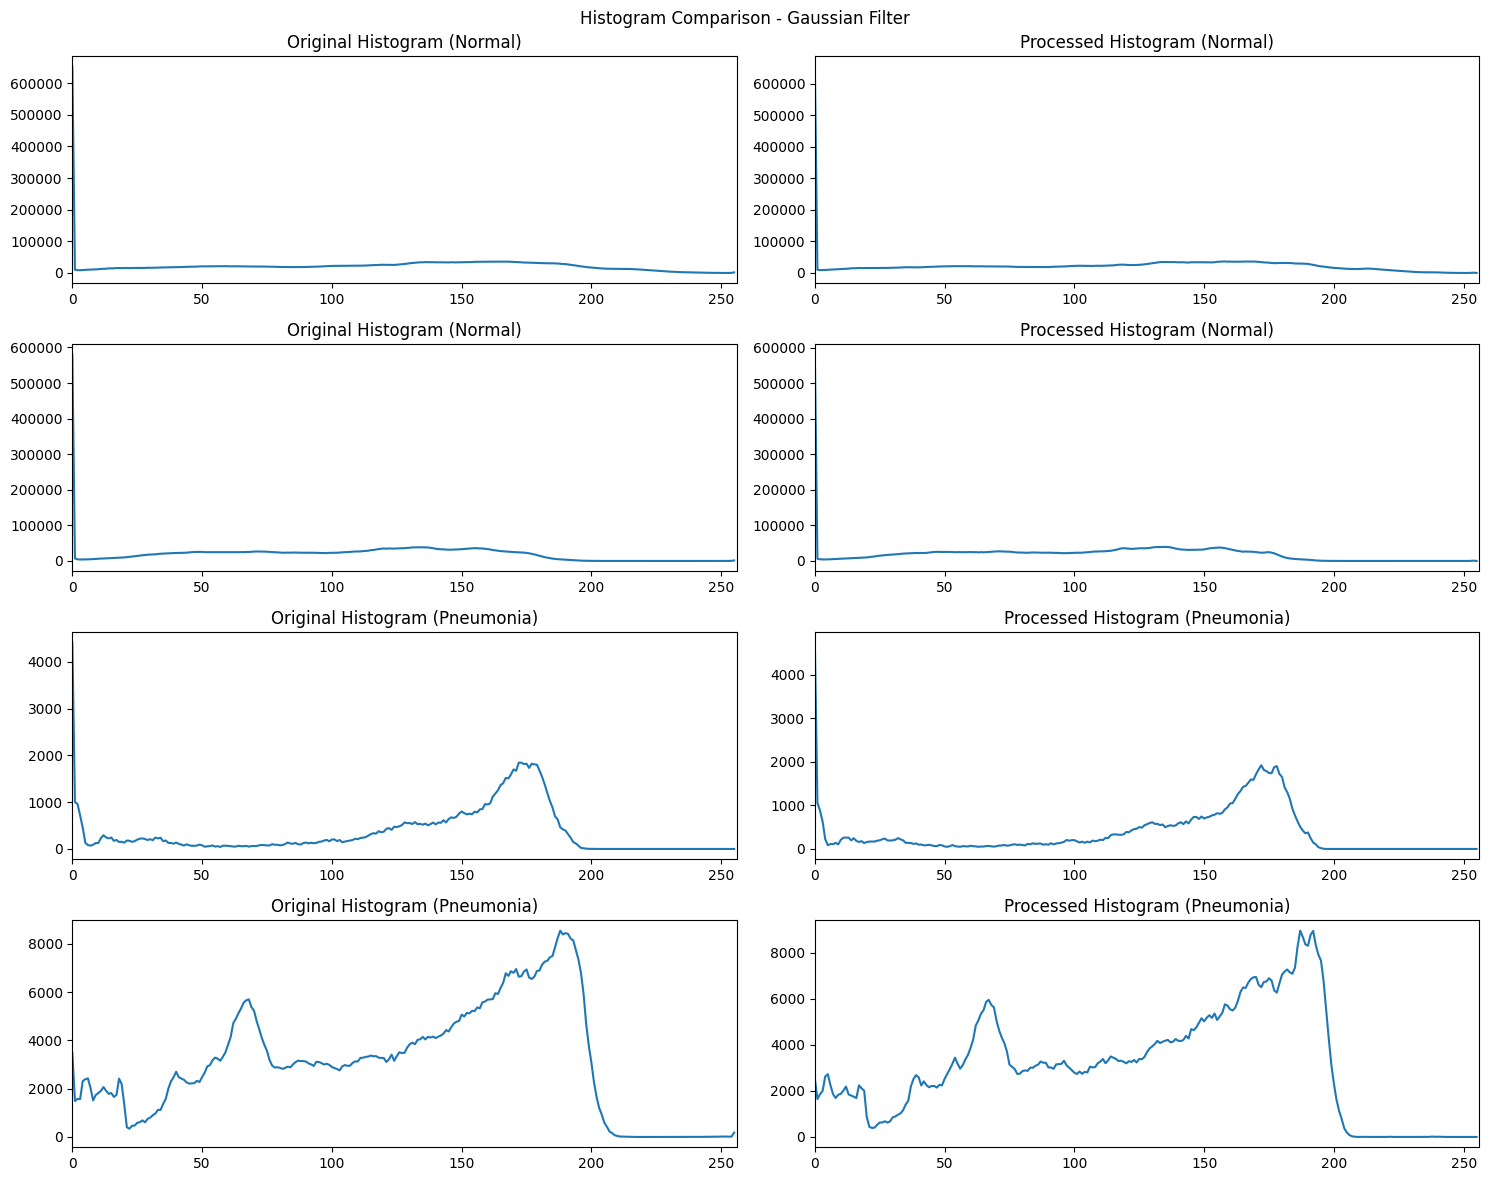

In [22]:
apply_preprocessing()

# Model building starts

We will be first trying some scikit learn classification models like Logistic Regression and Random Forest(ensemble model) , and see if it is predicting accurately

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.image import PatchExtractor
from skimage.feature import hog
from skimage.transform import resize

In [46]:
def extract_features(img_path, img_width=224, img_height=224):
    try:
        # Load image and convert to grayscale
        img = Image.open(img_path).convert('L')
        img = img.resize((img_width, img_height))
        img_array = np.array(img)

        # Extract HOG features
        hog_features = hog(img_array, orientations=9, pixels_per_cell=(16, 16),
                         cells_per_block=(2, 2), feature_vector=True)

        return hog_features
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [47]:
# Function to load and prepare data
def prepare_data(data_dir):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    features = []
    labels = []

    # Load NORMAL images
    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]
    for img_path in tqdm(normal_images, desc="Processing NORMAL images"):
        feature = extract_features(img_path)
        if feature is not None:
            features.append(feature)
            labels.append(0)  # 0 for NORMAL

    # Load PNEUMONIA images
    pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]
    for img_path in tqdm(pneumonia_images[:len(normal_images)], desc="Processing PNEUMONIA images"):  # Balancing data
        feature = extract_features(img_path)
        if feature is not None:
            features.append(feature)
            labels.append(1)  # 1 for PNEUMONIA

    return np.array(features), np.array(labels)

# Prepare training and testing data
print("Preparing training data...")
X_train, y_train = prepare_data(train_dir)
print("Preparing testing data...")
X_test, y_test = prepare_data(test_dir)

Preparing training data...


Processing PNEUMONIA images: 100%|██████████| 1341/1341 [00:24<00:00, 54.25it/s]


Preparing testing data...


Processing PNEUMONIA images: 100%|██████████| 234/234 [00:03<00:00, 61.03it/s]


In [48]:
from sklearn.linear_model import LogisticRegression

img_width, img_height = 224, 224

lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['NORMAL', 'PNEUMONIA']))

Logistic Regression Accuracy: 0.7415

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.66      0.99      0.79       234

    accuracy                           0.74       468
   macro avg       0.82      0.74      0.72       468
weighted avg       0.82      0.74      0.72       468



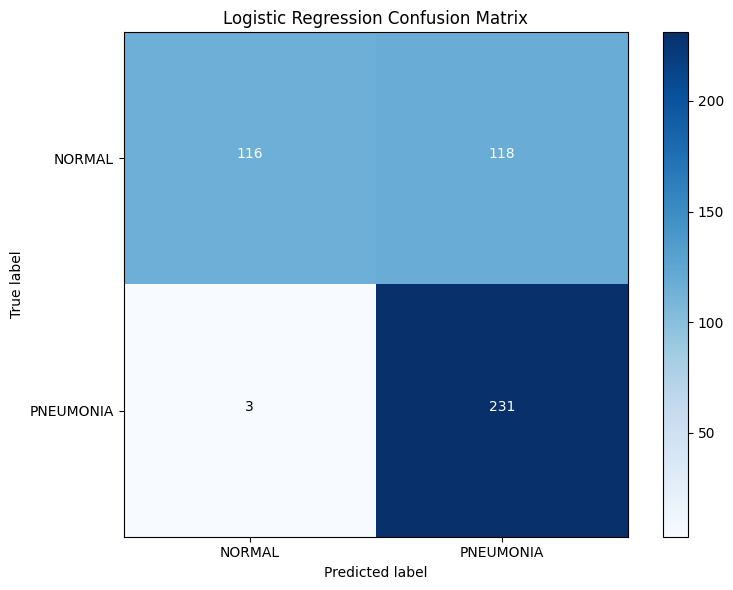

In [49]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, lr_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.yticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

It can be seen from the confusion matrix , that there are many normal labelled images which are predicted wrongly by our model

In [50]:
print("\n===== Random Forest Model =====")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['NORMAL', 'PNEUMONIA']))


===== Random Forest Model =====
Random Forest Accuracy: 0.7906

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.62      0.75       234
   PNEUMONIA       0.72      0.97      0.82       234

    accuracy                           0.79       468
   macro avg       0.83      0.79      0.78       468
weighted avg       0.83      0.79      0.78       468



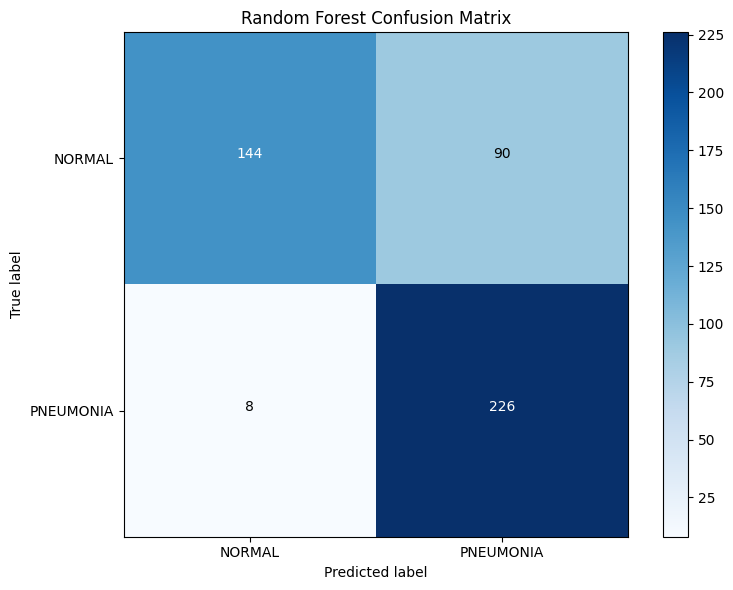

In [51]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.yticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

It can be seen from the confusion matrix , that there are many normal labelled images which are predicted wrongly by our model

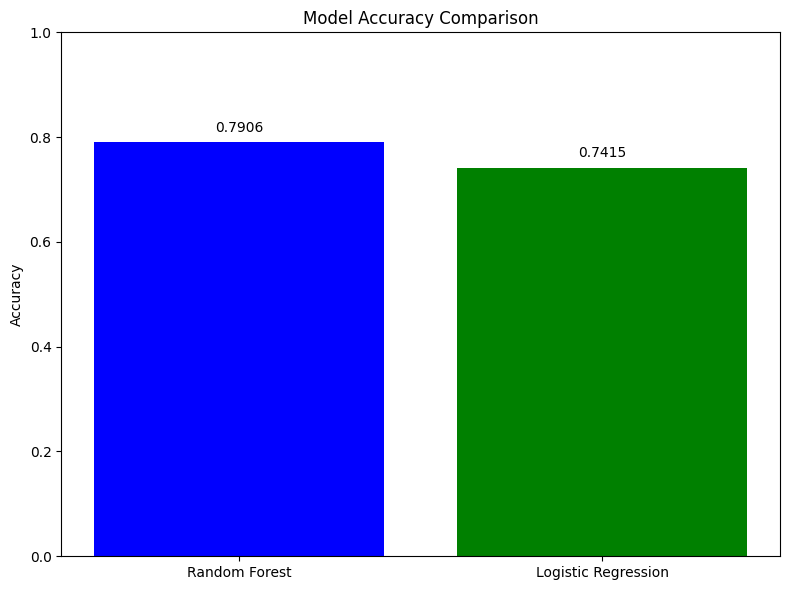

In [52]:
models = ['Random Forest', 'Logistic Regression']
accuracies = [rf_accuracy, lr_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

#Since we saw that random forest and logistic regression did not performed well , we would be now moving towards convolution neural networks

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [26]:
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [27]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,671,521 (197.11 MB)

 Trainable params: 51,669,601 (197.10 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [30]:
checkpoint = ModelCheckpoint(
    'pneumonia_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [31]:
callbacks = [checkpoint, early_stopping, reduce_lr]

In [32]:
normal_samples = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_samples = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_samples = normal_samples + pneumonia_samples
class_weight = {
    0: (total_samples / (2 * normal_samples)),
    1: (total_samples / (2 * pneumonia_samples))
}

print(f"Class weights: {class_weight}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [35]:
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks,
    class_weight=class_weight
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8483 - loss: 0.2964
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 522ms/step - accuracy: 0.8484 - loss: 0.2963 - val_accuracy: 0.5000 - val_loss: 24.6841 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8753 - loss: 0.2520
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 386ms/step - accuracy: 0.8753 - loss: 0.2519 - val_accuracy: 0.5000 - val_loss: 44.8628 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9072 - loss: 0.1999
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 386ms/step - accuracy: 0.9072 - loss: 0.1999 - val_accuracy: 0.5000 - val_loss: 5.0368 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9229 - loss: 0.1791
Epoch 4: val_accuracy improved from 0.50000 to 0.56250, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 423ms/step - accuracy: 0.9230 - loss: 0.1791 - val_accuracy: 0.5625 - val_loss: 0.6712 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9419 - loss: 0.1524
Epoch 5: val_accuracy improved from 0.56250 to 0.62500, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9418 - loss: 0.1525 - val_accuracy: 0.6250 - val_loss: 0.7857 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9394 - loss: 0.1622
Epoch 6: val_accuracy improved from 0.62500 to 0.75000, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 428ms/step - accuracy: 0.9394 - loss: 0.1621 - val_accuracy: 0.7500 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9347 - loss: 0.1616
Epoch 7: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 383ms/step - accuracy: 0.9348 - loss: 0.1615 - val_accuracy: 0.6875 - val_loss: 0.8244 - learning_rate: 1.0000e-04
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9454 - loss: 0.1422
Epoch 8: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 380ms/step - accuracy: 0.9454 - loss: 0.1422 - val_accuracy: 0.6875 - val_loss: 0.4844 - learning_rate: 1.0000e-04
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9454 - loss: 0.1490
Epoch 9: val_accuracy did not improve from 0.75000

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 376ms/step - accuracy: 0.9454

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.8413 - loss: 0.6319
Test accuracy: 0.8478


In [37]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

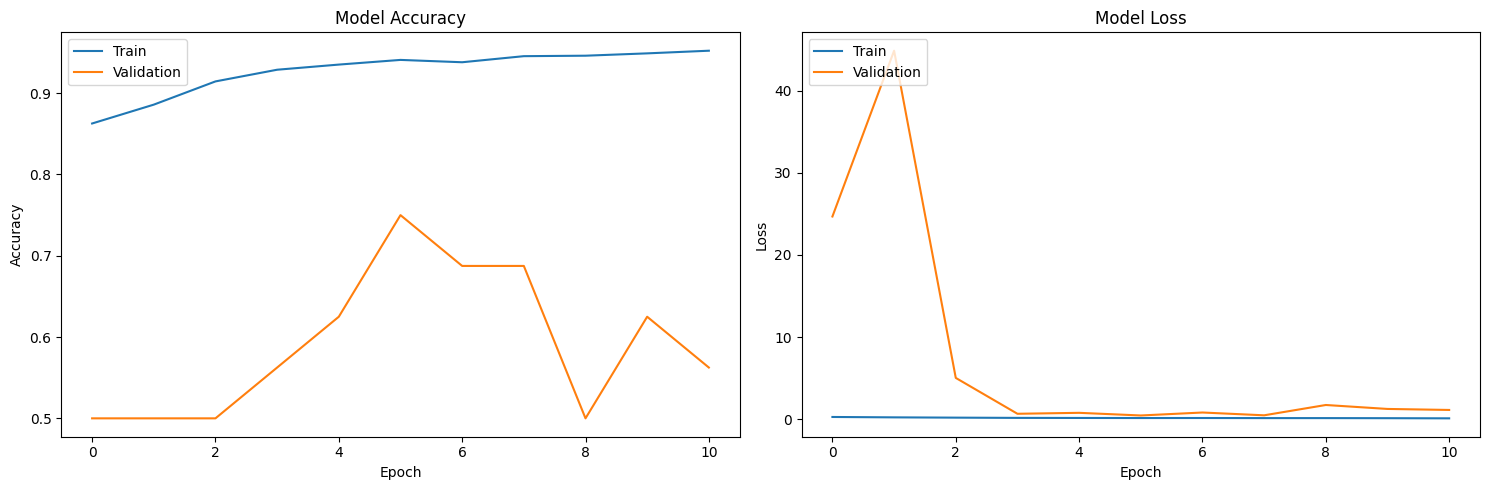

In [38]:
plot_training_history(history)

In [39]:
from tensorflow.keras.models import load_model
model = load_model("/content/pneumonia_model_best.h5")

# Make predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = y_pred.squeeze()  # Ensure correct shape

# Convert predictions to class labels
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

print("Predictions:", y_pred_classes)
print("True Labels:", y_true)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1

#Printing the classification report and plotting confusion matrix for model evaluation

In [40]:
print("Classification Report:")
target_names = ['Normal', 'Pneumonia']
print(classification_report(y_true, y_pred_classes, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.82      0.80       234
   Pneumonia       0.89      0.87      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



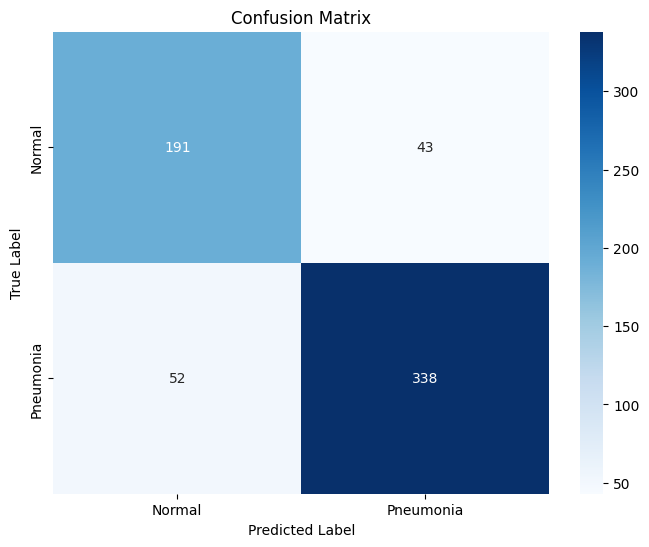

In [41]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, target_names)

We can see here that the problem of wrongly predicted normal labels has been resolved , thus improving accuracy

In [42]:
def predict_pneumonia(img_path):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.models import load_model

    # Load the best model
    model = load_model('pneumonia_model_best.h5')

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {'Pneumonia' if prediction > 0.5 else 'Normal'} ({prediction:.2f})")
    plt.axis('off')
    plt.show()

    return prediction